# Recommender System - Model Development
This notebook demonstrates building a recommendation system on the Amazon Reviews 2023 dataset. It includes data loading, preprocessing, model training, evaluation, and generating sample recommendations. The dataset is sourced from the Hugging Face datasets library [Amazon Reviews 2023](https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023) based on paper [Bridging Language and Items for Retrieval and Recommendation (2024)](
https://doi.org/10.48550/arXiv.2403.03952
).

In [1]:
import os
import random
import numpy as np
import pandas as pd
import time
import gc
import matplotlib.pyplot as plt
from collections import defaultdict

# os.environ["HF_HOME"] = "D:/Python Projects/recommendation_system"
# os.environ["HF_DATASETS_CACHE"] = "D:/Python Projects/recommendation_system/recsys/data"
# os.environ["TRANSFORMERS_CACHE"] = "D:/Python Projects/recommendation_system/recsys/models"

os.environ["HF_HOME"] = "E:/Python Scripts/recsys"
os.environ['HF_DATASETS_CACHE'] = "E:/Python Scripts/recsys/data"
os.environ['TRANSFORMERS_CACHE'] = "E:/Python Scripts/recsys/models"

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from datasets import load_dataset, Features, Value
from tqdm import tqdm
from tensorboardX import SummaryWriter

E:\Python Scripts\recsys\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 42
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

DEVICE: cuda


## Loading the dataset
The dataset is loaded from the Hugging Face datasets library, Amazon Reviews 2023.

In [3]:
USE_HF = True
HF_DATASET = "McAuley-Lab/Amazon-Reviews-2023"
HF_DOMAIN = "Books"   # choose your domain

def load_amazon_reviews_fast(domain: str, max_items: int | None = None, seed: int = SEED) -> pd.DataFrame:
    ds = load_dataset(
        "McAuley-Lab/Amazon-Reviews-2023",
        f"raw_review_{domain}",
        split="full",
        trust_remote_code=True,
    )

    # Keep only needed columns early
    ds = ds.select_columns(["user_id", "parent_asin", "rating", "verified_purchase", "timestamp"])

    # Rename + cast in Arrow (vectorized; no Python loop)
    ds = ds.rename_columns({"user_id": "user", "parent_asin": "item"})
    ds = ds.cast(Features({
        "user": Value("string"),
        "item": Value("string"),
        "rating": Value("float32"),
        "verified_purchase": Value("bool"),
        "timestamp": Value("int64"),   # seconds or ms as stored
    }))

    # Fast random subset without building a huge pandas frame first
    if max_items is not None:
        k = min(max_items, ds.num_rows)
        ds = ds.shuffle(seed=seed).select(range(k))

    # Convert to pandas (Arrow zero-copy where possible)
    df = ds.to_pandas()
    df.insert(3, "domain", domain)
    return df

df = load_amazon_reviews_fast(HF_DOMAIN, max_items=None, seed=SEED)
print(f"Loaded {len(df)} rows from {HF_DOMAIN} domain.")

Loaded 29475453 rows from Books domain.


In [4]:
df.head()

,user,item,rating,domain,verified_purchase,timestamp
0,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,B09BGPFTDB,1.0,Books,True,1642399598485
1,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,0593235657,5.0,Books,True,1640629604904
2,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1782490671,5.0,Books,True,1640383495102
3,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,0593138228,5.0,Books,False,1640364906602
4,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,0823098079,5.0,Books,True,1637312253230


## Preprocessing the dataset
- Make it implicit by considering all ratings as positive interactions.
- Filter out users and items with less than 5 interactions.
- Create a mapping of user and item IDs to indices.

In [5]:
# Make implicit dataset, filter users/items with less than k interactions
def preprocess_dataset(df, min_user_interactions=5, min_item_interactions=5):
    # Make it implicit
    df["label"] = 1.0
    # Filter users and items with less than 5 interactions
    user_counts = df["user"].value_counts()
    item_counts = df["item"].value_counts()
    valid_users = user_counts[user_counts >= min_user_interactions].index
    valid_items = item_counts[item_counts >= min_item_interactions].index
    df = df[df["user"].isin(valid_users) & df["item"].isin(valid_items)].copy()
    print("After interactions filtering:", len(df), "rows,", df["user"].nunique(), "users,", df["item"].nunique(), "items")
    return df

def label_encoder(df):
    df_enc = df.copy()
    user_enc = LabelEncoder()
    item_enc = LabelEncoder()
    df_enc["user_id"] = user_enc.fit_transform(df_enc["user"])
    df_enc["item_id"] = item_enc.fit_transform(df_enc["item"])
    return {"encoded_df": df_enc,
            "user_encoder": user_enc,
            "item_encoder": item_enc}

filtered_df = preprocess_dataset(df, min_user_interactions=20, min_item_interactions=20)
le = label_encoder(filtered_df)
df_encoded = le["encoded_df"]
user_enc = le["user_encoder"]
item_enc = le["item_encoder"]

After interactions filtering: 3532799 rows, 136560 users, 230834 items


In [6]:
def calculate_data_sparsity(df):
    num_users = df["user"].nunique()
    num_items = df["item"].nunique()
    num_interactions = len(df)
    density = num_interactions / (num_users * num_items)
    sparsity = 1 - density

    print(f"Number of users: {num_users}")
    print(f"Number of items: {num_items}")
    print(f"Number of interactions: {num_interactions}")
    print(f"-" * 30)
    print(f"Interaction Matrix Density: {density:.6f}")
    print(f"Interaction Matrix Sparsity: {sparsity:.6f}")

calculate_data_sparsity(df_encoded)

Number of users: 136560
Number of items: 230834
Number of interactions: 3532799
------------------------------
Interaction Matrix Density: 0.000112
Interaction Matrix Sparsity: 0.999888


In [7]:
def loo_split(df):
    df = df.sort_values(["user_id", "timestamp"])
    train_rows, val_rows, test_rows = [], [], []

    for uid, group in df.groupby("user_id", sort=False):
        g = group.sort_values("timestamp")
        if len(g) < 5:
            train_rows.append(g)
            continue
        test_rows.append(g.iloc[[-1]]) # Last interaction as test
        val_rows.append(g.iloc[[-2]]) # Second last interaction as validation
        train_rows.append(g.iloc[:-2]) # All but last two as training

    train_df = pd.concat(train_rows, ignore_index=True)
    val_df = pd.concat(val_rows, ignore_index=True)
    test_df = pd.concat(test_rows, ignore_index=True)

    return train_df, val_df, test_df

train_df, val_df, test_df = loo_split(df_encoded)
print(f"Train/Validation/Test split: {len(train_df)}, {len(val_df)}, {len(test_df)}")

Train/Validation/Test split: 3271857, 130471, 130471


## Building the dataset with negative sampling

In [8]:
NUM_USERS = df_encoded["user_id"].max() + 1
NUM_ITEMS = df_encoded["item_id"].max() + 1

In [9]:
# Rank the single positive against k negative samples for train and evaluation
def build_pos_items_by_user(train_df):
    pos_items_by_user = defaultdict(set)
    for u, i in zip(train_df["user_id"].values, train_df["item_id"].values):
        pos_items_by_user[u].add(int(i))
    return pos_items_by_user

In [10]:
# Training dataset with k negatives per positive
class ImplicitTrainingDataset(Dataset):
    def __init__(self, train_df, num_items, pos_by_user, neg_k=4, seed=SEED):
        self.pos_pairs = train_df[["user_id", "item_id"]].values.astype(np.int64)
        self.num_pos = len(self.pos_pairs)
        self.neg_k = neg_k
        self.num_items = num_items
        self.pos_by_user = pos_by_user
        self.length = self.num_pos * (1 + self.neg_k)
        self.rng = random.Random(seed)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        pos_idx = idx // (self.neg_k + 1)
        is_pos = (idx % (self.neg_k + 1) == 0)
        u, i_pos = self.pos_pairs[pos_idx]
        if is_pos:
            return int(u), int(i_pos), 1.0

        while True:
            j = self.rng.randint(0, self.num_items - 1)
            if j not in self.pos_by_user[u]:
                return int(u), int(j), 0.0

pos_items_by_user = build_pos_items_by_user(train_df)

train_dataset = ImplicitTrainingDataset(train_df,
                                  num_items=NUM_ITEMS,
                                  pos_by_user=pos_items_by_user,
                                  neg_k=4)
train_loader = DataLoader(train_dataset,
                          batch_size=4096,
                          shuffle=True)

print(f"Training dataset created with {len(train_dataset)} samples.")

Training dataset created with 16359285 samples.


In [11]:
class EvaluateDataset(Dataset):
    def __init__(self, eval_df, num_items, pos_by_user, n_neg=99, seed=42):
        self.users = eval_df["user_id"].values.astype(np.int64)
        self.pos_items = eval_df["item_id"].values.astype(np.int64)
        self.n_neg = n_neg
        self.num_items = num_items
        self.pos_by_user = pos_by_user

        rng = np.random.default_rng(seed)
        self.candidates = np.empty((len(self.users), 1 + n_neg), dtype=np.int64)

        for idx, (u, pos_i) in enumerate(zip(self.users, self.pos_items)):
            user_pos = pos_by_user[u].copy()
            user_pos.add(pos_i)
            negs = []
            while len(negs) < n_neg:
                neg = rng.integers(0, num_items)
                if neg not in user_pos:
                    negs.append(int(neg))
                    user_pos.add(neg)
            self.candidates[idx, 0] = pos_i
            self.candidates[idx, 1:] = np.asarray(negs, dtype=np.int64)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return int(self.users[idx]), self.candidates[idx]

# Build val/test loaders
val_dataset = EvaluateDataset(val_df, NUM_ITEMS, pos_items_by_user, n_neg=99, seed=SEED)
test_dataset = EvaluateDataset(test_df, NUM_ITEMS, pos_items_by_user, n_neg=99, seed=SEED)

val_loader = DataLoader(val_dataset, batch_size=4096, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4096, shuffle=False)

print(f"Validation dataset: {len(val_dataset)} users")
print(f"Test dataset: {len(test_dataset)} users")

Validation dataset: 130471 users
Test dataset: 130471 users


In [12]:
# Training dataset with k negatives per positive
class CustomDataset(Dataset):
    def __init__(self, df, num_items, pos_by_user, n_neg=4, mode="train", seed=SEED):
        self.pos_pairs = df[["user_id", "item_id"]].values.astype(np.int64)
        self.users = self.pos_pairs[:, 0]
        self.pos_items = self.pos_pairs[:, 1]
        self.num_items = num_items
        self.n_neg = n_neg
        self.mode = mode
        self.pos_by_user = pos_by_user
        self.rng = np.random.default_rng(seed)

        if mode == "val" or mode == "test":
            self.eval_candidates = np.empty((len(self.users), 1 + self.n_neg), dtype=np.int64)
            for idx, (u, pos_i) in enumerate(zip(self.users, self.pos_items)):
                user_pos = self.pos_by_user[u].copy()
                user_pos.add(pos_i)
                negs = []
                while len(negs) < self.n_neg:
                    neg = self.rng.integers(0, self.num_items)
                    if neg not in user_pos:
                        negs.append(int(neg))
                        user_pos.add(neg)
                self.eval_candidates[idx, 0] = pos_i
                self.eval_candidates[idx, 1:] = np.asarray(negs, dtype=np.int64)

    def __len__(self):
        return len(self.pos_pairs) * (1 + self.n_neg) if self.mode == "train" else len(self.users)

    def __getitem__(self, idx):
        if self.mode == "train":
            return self._get_train_item(idx)
        else:
            return self._get_eval_item(idx)

    def _get_train_item(self, idx):
        pos_idx = idx // (self.n_neg + 1)
        is_pos = (idx % (self.n_neg + 1) == 0)
        u, i_pos = self.pos_pairs[pos_idx]
        if is_pos:
            return int(u), int(i_pos), 1.0

        while True:
            j = self.rng.integers(0, self.num_items - 1)
            if j not in self.pos_by_user[u]:
                return int(u), int(j), 0.0

    def _get_eval_item(self, idx):
        return int(self.users[idx]), self.eval_candidates[idx]


pos_items_by_user = build_pos_items_by_user(train_df)

train_dataset = CustomDataset(train_df, num_items=NUM_ITEMS, pos_by_user=pos_items_by_user, n_neg=4, mode="train", seed=SEED)
train_loader = DataLoader(train_dataset, batch_size=4096, shuffle=True)

val_dataset = CustomDataset(val_df, num_items=NUM_ITEMS, pos_by_user=pos_items_by_user, n_neg=99, mode="val", seed=SEED)
val_loader = DataLoader(val_dataset, batch_size=4096, shuffle=False)

test_dataset = CustomDataset(test_df, num_items=NUM_ITEMS, pos_by_user=pos_items_by_user, n_neg=99, mode="test", seed=SEED)
test_loader = DataLoader(test_dataset, batch_size=4096, shuffle=False)

print(f"Training dataset created with {len(train_dataset)} samples.")
print(f"Validation dataset created with {len(val_dataset)} samples.")
print(f"Test dataset created with {len(test_dataset)} samples.")

Training dataset created with 16359285 samples.
Validation dataset created with 130471 samples.
Test dataset created with 130471 samples.


## Utility functions for training and evaluation
- Train one epoch
- For each val user, build candidate set = `{positive} U {k negatives}`
- Score, sort, compute HR@K, NDCG@K, Precision@K, MAP@K

In [13]:
def train_epoch(model, train_loader, loss_fn, optimizer, device="cpu"):
    model.train()
    running_loss = 0.0
    n_batches = 0

    for batch in tqdm(train_loader, desc="Training"):
        users, items, labels = batch
        users = users.to(device, non_blocking=True)
        items = items.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(users, items)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        n_batches += 1

    epoch_loss = running_loss / max(n_batches, 1)
    return epoch_loss

In [14]:
# Validation loss and ranking metrics
@torch.no_grad()
def evaluate(model, eval_loader, loss_fn, k=10, device="cpu"):
    model.eval()
    total = 0
    sum_hr = 0.0
    sum_ndcg = 0.0
    sum_prec = 0.0
    sum_ap = 0.0

    sum_val_loss = 0.0
    n_loss_batches = 0

    for users, cand in tqdm(eval_loader, desc="Evaluating"):
        users = users.to(device, non_blocking=True)
        cand = torch.as_tensor(cand, dtype=torch.long, device=device)
        B, C = cand.shape

        # Repeat users per candidate, score in one forward
        users_rep = users.view(-1, 1).expand(-1, C).reshape(-1)
        items_flat = cand.reshape(-1)
        scores_flat = model(users_rep, items_flat)
        scores = scores_flat.view(B, C)

        # Rank of the positive (column 0)
        pos = scores[:, 0].unsqueeze(1)  # [B,1]
        # number of items with strictly greater score than the positive +1
        rank = (scores[:, 1:] > pos).sum(dim=1).add_(1).to(torch.long)  # [B]

        hit = (rank <= k).float()
        ndcg = torch.where(rank <= k, 1.0 / torch.log2(rank.float() + 1), torch.zeros_like(hit))
        precision = hit / float(k)
        ap = torch.where(rank <= k, 1.0 / rank.float(), torch.zeros_like(hit))

        sum_hr += hit.sum().item()
        sum_ndcg += ndcg.sum().item()
        sum_prec += precision.sum().item()
        sum_ap += ap.sum().item()
        total += B

        # Validation loss: labels = [1, 0, 0, ...]
        labels = torch.zeros_like(scores)
        labels[:, 0] = 1.0
        batch_loss = loss_fn(scores, labels)
        sum_val_loss += batch_loss.item()
        n_loss_batches += 1

    metrics = {
        "HR@K": sum_hr / total if total else 0.0,
        "NDCG@K": sum_ndcg / total if total else 0.0,
        "Precision@K": sum_prec / total if total else 0.0,
        "MAP@K": sum_ap / total if total else 0.0,
        "Val loss": sum_val_loss / max(n_loss_batches, 1)
    }
    return metrics

## Train loop

In [15]:
def model_trainer(
        model,
        train_loader,
        eval_loader,
        epochs,
        loss_fn,
        optimizer,
        k=10,             # kept to log hyperparams
        device="cpu",
        save_dir="model"
    ):
    os.makedirs(save_dir, exist_ok=True)
    model.to(device)
    writer = SummaryWriter()

    train_losses, val_losses, val_metrics_log = [], [], []
    best_ndcg, best_epoch = 0.0, 0

    for epoch in range(epochs):
        t0 = time.time()

        # Train (batched)
        train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device=device)
        train_losses.append(train_loss)

        # Eval (batched)
        m = evaluate(model, eval_loader, loss_fn, k=k, device=device)
        val_losses.append(m["Val loss"])
        val_metrics_log.append({k_: m[k_] for k_ in ["HR@K", "NDCG@K", "Precision@K", "MAP@K"]})

        # Checkpointing by NDCG
        if m["NDCG@K"] > best_ndcg:
            best_ndcg = m["NDCG@K"]
            best_epoch = epoch + 1
            torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pth"))
        torch.save(model.state_dict(), os.path.join(save_dir, "last_model.pth"))

        # TB logs
        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Loss/Validation", m["Val loss"], epoch)
        writer.add_scalar(f"Metrics/Val_HR@{k}", m["HR@K"], epoch)
        writer.add_scalar(f"Metrics/Val_NDCG@{k}", m["NDCG@K"], epoch)
        writer.add_scalar(f"Metrics/Val_Precision@{k}", m["Precision@K"], epoch)
        writer.add_scalar(f"Metrics/Val_MAP@{k}", m["MAP@K"], epoch)

        print(
            f"Epoch {epoch+1}/{epochs}  "
            f"Train loss {train_loss:.4f}  "
            f"Val loss {m['Val loss']:.4f}  "
            f"HR@{k} {m['HR@K']:.4f}  "
            f"NDCG@{k} {m['NDCG@K']:.4f}  "
            f"Precision@{k} {m['Precision@K']:.4f}  "
            f"MAP@{k} {m['MAP@K']:.4f}  "
            f"{'(new best)' if m['NDCG@K'] == best_ndcg and best_epoch==epoch+1 else ''}  "
            f"Time {time.time()-t0:.2f}s"
        )

    # print("\n" + "="*50)
    print("\nTraining Complete.")
    print(f"Best epoch: {best_epoch} with NDCG@{k}: {best_ndcg:.4f}\n")
    # print("="*50)
    # print("\n")

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    writer.close()
    return train_losses, val_losses, val_metrics_log, best_ndcg

## Baseline model: Matrix factorization

A simple Matrix Factorization model with user and item embeddings with dot product scoring.

In [16]:
# Simple Matrix Factorization model (dot product)
class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_items, embedding_dim):
        super().__init__()
        self.user_embed = nn.Embedding(n_users, embedding_dim)
        self.item_embed = nn.Embedding(n_items, embedding_dim)
        nn.init.xavier_uniform_(self.user_embed.weight)
        nn.init.xavier_uniform_(self.item_embed.weight)

    def forward(self, user_ids, item_ids):
        user_embeds = self.user_embed(user_ids)
        item_embeds = self.item_embed(item_ids)
        dot_product = (user_embeds * item_embeds).sum(dim=1, keepdim=True)
        return dot_product.squeeze()

    def predict_all_items(self, user_id):
        """Predict scores for all items for a given user"""
        user_tensor = torch.tensor([user_id], dtype=torch.long).to(next(self.parameters()).device)
        all_items = torch.arange(self.item_embed.num_embeddings).to(next(self.parameters()).device)
        user_embeds = self.user_embed(user_tensor)
        item_embeds = self.item_embed(all_items)
        scores = torch.matmul(user_embeds, item_embeds.T).squeeze()
        return torch.sigmoid(scores)

In [17]:
# Run the training
model = MatrixFactorization(n_users=NUM_USERS, n_items=NUM_ITEMS, embedding_dim=64).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

train_losses, val_losses, val_metrics, best_ndcg = model_trainer(
    model=model,
    train_loader=train_loader,
    eval_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=20,
    k=10,
    device=DEVICE
)

Evaluating: 100%|██████████| 32/32 [00:01<00:00, 30.69it/s]


Epoch 1/20  Train loss 0.5873  Val loss 0.5054  HR@10 0.3192  NDCG@10 0.1913  Precision@10 0.0319  MAP@10 0.1523  (new best)  Time 120.26s


Evaluating: 100%|██████████| 32/32 [00:00<00:00, 34.15it/s]


Epoch 2/20  Train loss 0.5015  Val loss 0.4964  HR@10 0.3221  NDCG@10 0.1937  Precision@10 0.0322  MAP@10 0.1544  (new best)  Time 122.78s


Evaluating: 100%|██████████| 32/32 [00:01<00:00, 24.74it/s]


Epoch 3/20  Train loss 0.4983  Val loss 0.4950  HR@10 0.3271  NDCG@10 0.1976  Precision@10 0.0327  MAP@10 0.1579  (new best)  Time 123.94s


Evaluating: 100%|██████████| 32/32 [00:00<00:00, 35.48it/s]


Epoch 4/20  Train loss 0.4957  Val loss 0.4942  HR@10 0.3348  NDCG@10 0.2024  Precision@10 0.0335  MAP@10 0.1618  (new best)  Time 121.12s


Evaluating: 100%|██████████| 32/32 [00:01<00:00, 25.56it/s]


Epoch 5/20  Train loss 0.4934  Val loss 0.4928  HR@10 0.3409  NDCG@10 0.2062  Precision@10 0.0341  MAP@10 0.1650  (new best)  Time 124.11s


Evaluating: 100%|██████████| 32/32 [00:00<00:00, 35.48it/s]


Epoch 6/20  Train loss 0.4914  Val loss 0.4921  HR@10 0.3431  NDCG@10 0.2088  Precision@10 0.0343  MAP@10 0.1676  (new best)  Time 123.60s


Evaluating: 100%|██████████| 32/32 [00:00<00:00, 37.23it/s]


Epoch 7/20  Train loss 0.4899  Val loss 0.4917  HR@10 0.3467  NDCG@10 0.2109  Precision@10 0.0347  MAP@10 0.1693  (new best)  Time 122.51s


Evaluating: 100%|██████████| 32/32 [00:00<00:00, 35.91it/s]


Epoch 8/20  Train loss 0.4885  Val loss 0.4911  HR@10 0.3505  NDCG@10 0.2132  Precision@10 0.0351  MAP@10 0.1711  (new best)  Time 121.09s


Evaluating: 100%|██████████| 32/32 [00:01<00:00, 25.55it/s]


Epoch 9/20  Train loss 0.4875  Val loss 0.4906  HR@10 0.3520  NDCG@10 0.2150  Precision@10 0.0352  MAP@10 0.1729  (new best)  Time 120.76s


Evaluating: 100%|██████████| 32/32 [00:00<00:00, 35.32it/s]


Epoch 10/20  Train loss 0.4868  Val loss 0.4904  HR@10 0.3536  NDCG@10 0.2158  Precision@10 0.0354  MAP@10 0.1735  (new best)  Time 120.08s


Evaluating: 100%|██████████| 32/32 [00:01<00:00, 24.86it/s]


Epoch 11/20  Train loss 0.4862  Val loss 0.4901  HR@10 0.3548  NDCG@10 0.2167  Precision@10 0.0355  MAP@10 0.1742  (new best)  Time 121.04s


Evaluating: 100%|██████████| 32/32 [00:00<00:00, 35.83it/s]


Epoch 12/20  Train loss 0.4856  Val loss 0.4900  HR@10 0.3546  NDCG@10 0.2171  Precision@10 0.0355  MAP@10 0.1749  (new best)  Time 121.40s


Evaluating: 100%|██████████| 32/32 [00:00<00:00, 35.12it/s]


Epoch 13/20  Train loss 0.4852  Val loss 0.4898  HR@10 0.3563  NDCG@10 0.2177  Precision@10 0.0356  MAP@10 0.1751  (new best)  Time 120.47s


Evaluating: 100%|██████████| 32/32 [00:00<00:00, 35.31it/s]


Epoch 14/20  Train loss 0.4850  Val loss 0.4897  HR@10 0.3568  NDCG@10 0.2179  Precision@10 0.0357  MAP@10 0.1752  (new best)  Time 121.04s


Evaluating: 100%|██████████| 32/32 [00:01<00:00, 25.20it/s]


Epoch 15/20  Train loss 0.4848  Val loss 0.4898  HR@10 0.3581  NDCG@10 0.2188  Precision@10 0.0358  MAP@10 0.1760  (new best)  Time 120.70s


Evaluating: 100%|██████████| 32/32 [00:01<00:00, 24.83it/s]


Epoch 16/20  Train loss 0.4846  Val loss 0.4896  HR@10 0.3576  NDCG@10 0.2188  Precision@10 0.0358  MAP@10 0.1762    Time 118.64s


Evaluating: 100%|██████████| 32/32 [00:00<00:00, 35.40it/s]


Epoch 17/20  Train loss 0.4844  Val loss 0.4894  HR@10 0.3590  NDCG@10 0.2197  Precision@10 0.0359  MAP@10 0.1769  (new best)  Time 120.49s


Evaluating: 100%|██████████| 32/32 [00:01<00:00, 24.03it/s]


Epoch 18/20  Train loss 0.4842  Val loss 0.4896  HR@10 0.3572  NDCG@10 0.2195  Precision@10 0.0357  MAP@10 0.1771    Time 121.38s


Evaluating: 100%|██████████| 32/32 [00:00<00:00, 35.93it/s]


Epoch 19/20  Train loss 0.4841  Val loss 0.4895  HR@10 0.3589  NDCG@10 0.2197  Precision@10 0.0359  MAP@10 0.1770    Time 117.24s


Evaluating: 100%|██████████| 32/32 [00:01<00:00, 26.45it/s]


Epoch 20/20  Train loss 0.4840  Val loss 0.4893  HR@10 0.3580  NDCG@10 0.2188  Precision@10 0.0358  MAP@10 0.1761    Time 117.45s

Training Complete.
Best epoch: 17 with NDCG@10: 0.2197



## Final evaluation on test set and sample recommendations

In [18]:
def load_best_weights(model, ckpt_path="model/best_model.pth", device=None):
    """Load best checkpoint into the provided model."""
    if device is None:
        device = next(model.parameters()).device
    if not os.path.exists(ckpt_path):
        raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}")
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state)
    model.to(device)
    model.eval()
    return model

best_model = load_best_weights(model, ckpt_path="model/best_model.pth", device=DEVICE)

In [19]:
# Final evaluation on test set
@torch.no_grad()
def final_evaluation_loader(model, test_loader, loss_fn, k_values=(5,10,20,50), device="cpu") -> pd.DataFrame:
    rows = []
    for k in k_values:
        metrics = evaluate(model, test_loader, loss_fn, k=k, device=device)
        rows.append({
            "K": k,
            "HR@K": metrics["HR@K"],
            "NDCG@K": metrics["NDCG@K"],
            "Precision@K": metrics["Precision@K"],
        })
    df = pd.DataFrame(rows).set_index("K").sort_index()
    print(df.to_string(float_format=lambda x: f"{x:.4f}"))
    return df

results_df_mf = final_evaluation_loader(best_model, test_loader, loss_fn, device=DEVICE)

Evaluating: 100%|██████████| 32/32 [00:01<00:00, 28.11it/s]

     HR@K  NDCG@K  Precision@K
K                             
5  0.2494  0.1777       0.0499
10 0.3383  0.2063       0.0338
20 0.4542  0.2354       0.0227
50 0.6964  0.2831       0.0139


In [20]:
@torch.no_grad()
def get_recommendations(
    model, user_id, pos_items_by_user, item_encoder, top_k=10, exclude_interacted=True, as_prob=False
):
    model.eval()
    scores = model.predict_all_items(user_id)  # logits
    if exclude_interacted and user_id in pos_items_by_user:
        idx = torch.as_tensor(list(pos_items_by_user[user_id]), dtype=torch.long, device=scores.device)
        if idx.numel() > 0:
            scores.index_fill_(0, idx, float('-inf'))

    top_scores, top_indices = torch.topk(scores, k=top_k)
    shown = torch.sigmoid(top_scores) if as_prob else top_scores

    item_ids_np = top_indices.detach().cpu().numpy()
    items_np = item_encoder.inverse_transform(item_ids_np)
    return [{"item_id": int(i), "item": it, "score": float(s)} for i, it, s in zip(item_ids_np, items_np, shown.detach().cpu().numpy())]

In [21]:
def build_history_by_user(df):
    # df must contain user_id, item_id, timestamp (ints)
    df_sorted = df.sort_values(["user_id", "timestamp"])
    hist = defaultdict(list)
    for u, i in zip(df_sorted["user_id"].values, df_sorted["item_id"].values):
        hist[u].append(int(i))
    return hist

# Build once (choose train_df or filtered_df depending on story you want)
history_by_user_train = build_history_by_user(train_df)
history_by_user_full = build_history_by_user(df_encoded)

In [22]:
def show_sample_recommendations(
    model,
    df,
    user_encoder,
    item_encoder,
    pos_items_by_user,     # pass train-only OR full here, same as get_recommendations
    history_by_user,       # pass the matching history dict (train or full)
    num_users=5,
    top_k=10
):
    print("\n" + "="*50)
    print("User Sample Recommendations")
    print("="*50)

    user_candidates = df["user_id"].unique().tolist()
    for user_id in random.sample(user_candidates, k=min(num_users, len(user_candidates))):
        original_user = user_encoder.inverse_transform([user_id])[0]
        print(f"\nUser: {original_user} (ID: {user_id})")
        print("-" * 40)

        recent = history_by_user.get(user_id, [])[-5:]  # last 5 chronologically
        print("Recent interactions:")
        for item_id in reversed(recent):  # most recent first
            print("  -", item_encoder.inverse_transform([item_id])[0])

        recs = get_recommendations(
            model,
            user_id=user_id,
            pos_items_by_user=pos_items_by_user,
            item_encoder=item_encoder,
            top_k=top_k,
            exclude_interacted=True
        )
        print("\nTop 10 Recommendations:")
        for i, rec in enumerate(recs, 1):
            print(f"  {i}. {rec['item']} (Score: {rec['score']:.4f})")

In [23]:
# “Online-style” (no future knowledge):
show_sample_recommendations(
    best_model,
    df_encoded,
    user_enc,
    item_enc,
    pos_items_by_user=pos_items_by_user,     # exclude TRAIN-only
    history_by_user=history_by_user_train,
    num_users=5, top_k=10
)


User Sample Recommendations

User: AGL4IVAZIC5ZS4LEEATFISEKFDFA (ID: 86604)
----------------------------------------
Recent interactions:
  - B07GR4NWFQ
  - B075665WN5
  - 0028630238
  - B002IFSR6Y
  - 161765650X

Top 10 Recommendations:
  1. B00L9B7IKE (Score: 0.9532)
  2. B006LSZECO (Score: 0.9501)
  3. B00JO8PEN2 (Score: 0.9344)
  4. B00DPM7TIG (Score: 0.9257)
  5. B016ZNRC0Q (Score: 0.9253)
  6. B06Y1264PX (Score: 0.9176)
  7. B00CNQ7HAU (Score: 0.9037)
  8. B00YTXTIDO (Score: 0.9026)
  9. B01M7XPGYE (Score: 0.8899)
  10. B00C2WDD5I (Score: 0.8899)

User: AGVKCYW5RVRP2CELCHPDFTHZZ6AA (ID: 97663)
----------------------------------------
Recent interactions:
  - 0840701357
  - 1580117953
  - 1627107452
  - 1580117619
  - 080245965X

Top 10 Recommendations:
  1. B00L9B7IKE (Score: 0.7682)
  2. B006LSZECO (Score: 0.7669)
  3. B00JO8PEN2 (Score: 0.7386)
  4. B00DPM7TIG (Score: 0.7352)
  5. B016ZNRC0Q (Score: 0.7273)
  6. B06Y1264PX (Score: 0.7143)
  7. 030758836X (Score: 0.7062)
  8. 0

## Plotting training history

In [24]:
def plot_training_history(train_losses, val_losses, val_metrics, k, model_name, save_path="training_history.png"):
    """Plot training history and validation metrics"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f"{model_name}", fontsize=16)

    # Plot training and validation loss
    axes[0, 0].plot(train_losses, label="Training Loss", color="blue")
    axes[0, 0].plot(val_losses, label="Validation Loss", color="red")
    axes[0, 0].set_xlabel("Epoch")
    axes[0, 0].set_ylabel("Loss")
    axes[0, 0].set_title("Training vs Validation Loss")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot training loss
    #axes[0, 0].plot(train_losses, label="Training Loss", color="blue")
    #axes[0, 0].set_xlabel("Epoch")
    #axes[0, 0].set_ylabel("Loss")
    #axes[0, 0].set_title("Training Loss")
    #axes[0, 0].legend()
    #axes[0, 0].grid(True, alpha=0.3)

    # Plot HR@k
    hr_values = [m["HR@K"] for m in val_metrics]
    axes[0, 1].plot(hr_values, label=f"Val HR@{k}", color="green", marker="o")
    axes[0, 1].set_xlabel("Epoch")
    axes[0, 1].set_ylabel(f"HR@{k}")
    axes[0, 1].set_title(f"Validation Hit Rate@{k}")
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot NDCG@k
    ndcg_values = [m["NDCG@K"] for m in val_metrics]
    axes[0, 2].plot(ndcg_values, label=f"Val NDCG@{k}", color="orange", marker="s")
    axes[0, 2].set_xlabel("Epoch")
    axes[0, 2].set_ylabel(f"NDCG@{k}")
    axes[0, 2].set_title(f"Validation NDCG@{k}")
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # Plot Precision@k
    precision_values = [m["Precision@K"] for m in val_metrics]
    axes[1, 0].plot(precision_values, label=f"Val Precision@{k}", color="purple", marker="^")
    axes[1, 0].set_xlabel("Epoch")
    axes[1, 0].set_ylabel(f"Precision@{k}")
    axes[1, 0].set_title(f"Validation Precision@{k}")
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Plot Recall@k
    recall_values = [m["MAP@K"] for m in val_metrics]
    axes[1, 1].plot(recall_values, label=f"Val MAP@{k}", color="brown", marker="v")
    axes[1, 1].set_xlabel("Epoch")
    axes[1, 1].set_ylabel(f"MAP@{k}")
    axes[1, 1].set_title(f"Validation MAP@{k}")
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Plot all metrics together for comparison
    axes[1, 2].plot(hr_values, label=f"HR@{k}", marker="o")
    axes[1, 2].plot(ndcg_values, label=f"NDCG@{k}", marker="s")
    axes[1, 2].plot(precision_values, label=f"Precision@{k}", marker="^")
    axes[1, 2].plot(recall_values, label=f"MAP@{k}", marker="v")
    axes[1, 2].set_xlabel("Epoch")
    axes[1, 2].set_ylabel("Score")
    axes[1, 2].set_title("All Validation Metrics Comparison")
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=100, bbox_inches="tight")
    plt.show()

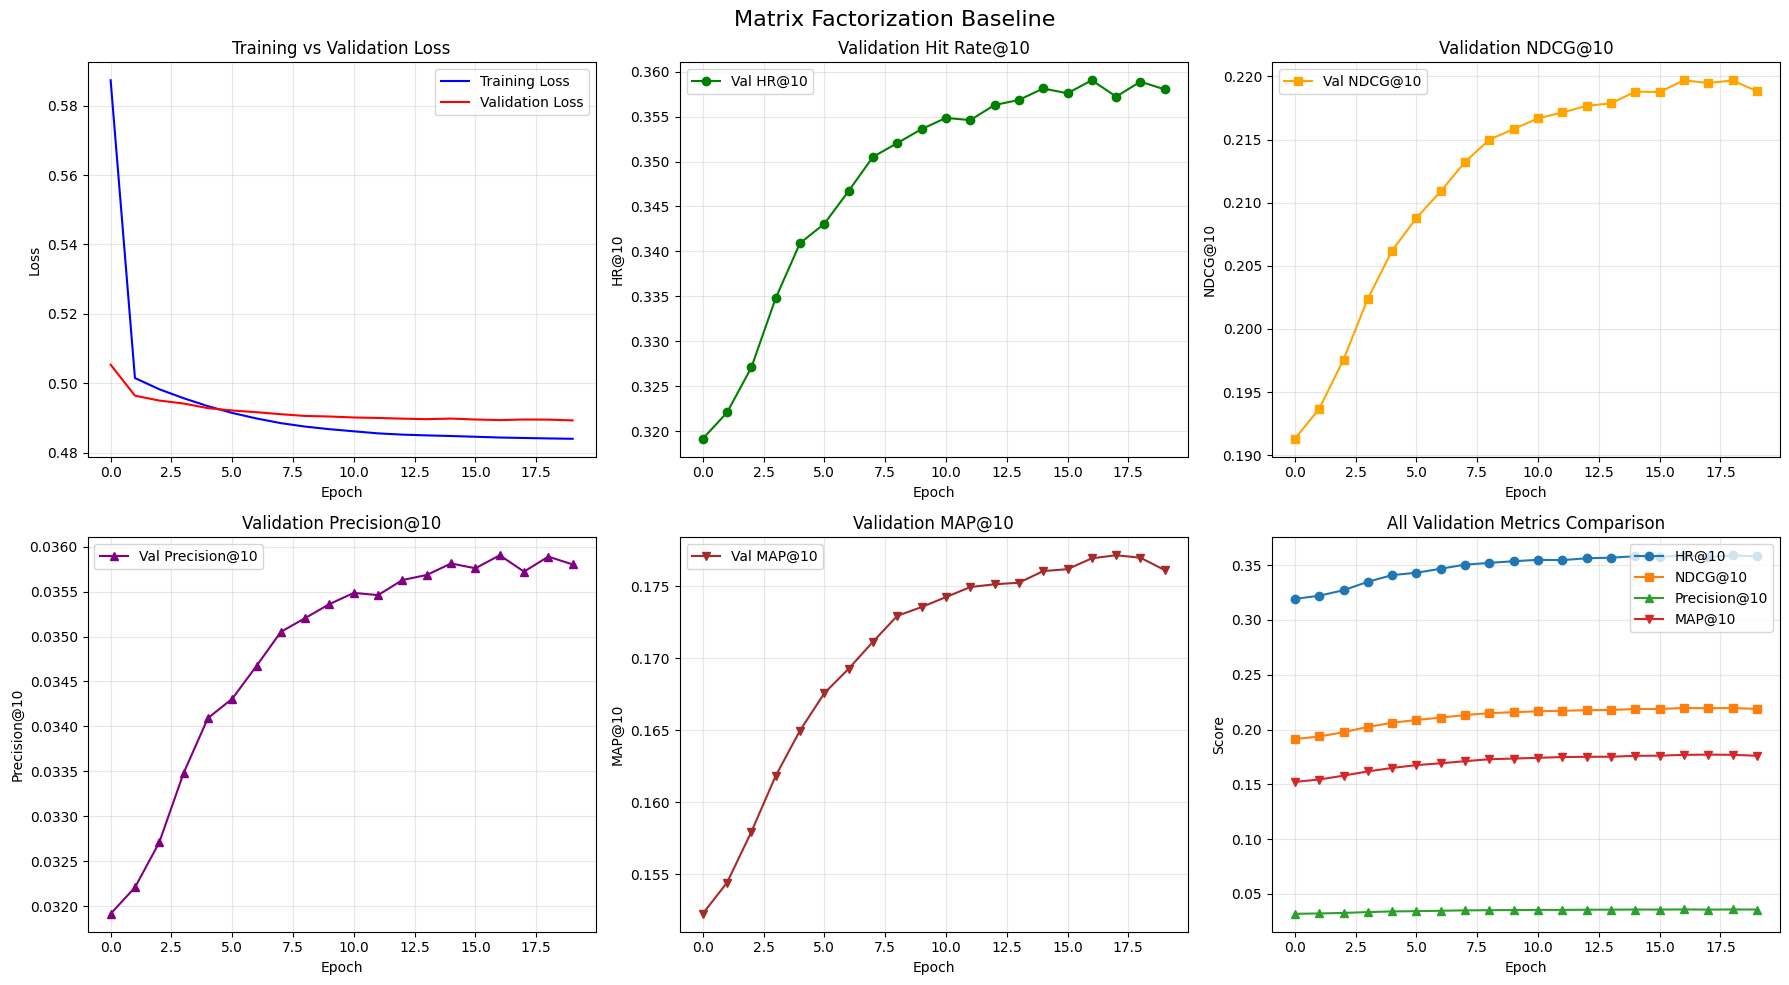

In [25]:
plot_training_history(
    train_losses,
    val_losses,
    val_metrics,
    k=10,
    model_name="Matrix Factorization Baseline",
    save_path="training_history.png"
)

## Model 1: Neural matrix factorization model

In [32]:
class NeuralMF(nn.Module):
    """
    NeuMF: GMF (dot-style) + MLP (nonlinear) with optional user/item/global biases.
    Returns raw logits suitable for BCEWithLogitsLoss.
    """
    def __init__(
        self,
        n_users: int,
        n_items: int,
        gmf_dim: int = 32,
        mlp_dim: int = 32,
        mlp_layers=(64, 32, 16),
        dropout: float = 0.1,
        use_bias: bool = True,
    ):
        super().__init__()
        # GMF branch
        self.user_emb_gmf = nn.Embedding(n_users, gmf_dim)
        self.item_emb_gmf = nn.Embedding(n_items, gmf_dim)

        # MLP branch
        self.user_emb_mlp = nn.Embedding(n_users, mlp_dim)
        self.item_emb_mlp = nn.Embedding(n_items, mlp_dim)

        mlp_blocks = []
        in_dim = mlp_dim * 2
        for h in mlp_layers:
            mlp_blocks.append(nn.Linear(in_dim, h))
            mlp_blocks.append(nn.ReLU())
            if dropout and dropout > 0:
                mlp_blocks.append(nn.Dropout(dropout))
            in_dim = h
        self.mlp = nn.Sequential(*mlp_blocks) if mlp_blocks else nn.Identity()

        # Final combine: concat(GMF, MLP) -> 1
        final_in = gmf_dim + (mlp_layers[-1] if mlp_blocks else mlp_dim * 2)
        self.fc_out = nn.Linear(final_in, 1)

        self.use_bias = use_bias
        if use_bias:
            self.user_bias = nn.Embedding(n_users, 1)
            self.item_bias = nn.Embedding(n_items, 1)
        else:
            self.user_bias = None
            self.item_bias = None
        self.global_bias = nn.Parameter(torch.zeros(1))

        self._reset_parameters()

    def _reset_parameters(self):
        for emb in [self.user_emb_gmf, self.item_emb_gmf, self.user_emb_mlp, self.item_emb_mlp]:
            nn.init.xavier_uniform_(emb.weight)
        for m in self.mlp:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
        nn.init.xavier_uniform_(self.fc_out.weight)
        nn.init.zeros_(self.fc_out.bias)
        if self.use_bias:
            nn.init.zeros_(self.user_bias.weight)
            nn.init.zeros_(self.item_bias.weight)

    def forward(self, user_ids, item_ids):
        # GMF
        gmf_u = self.user_emb_gmf(user_ids)           # [B, gmf_dim]
        gmf_i = self.item_emb_gmf(item_ids)           # [B, gmf_dim]
        gmf   = gmf_u * gmf_i                         # [B, gmf_dim]  (element-wise product)

        # MLP
        mlp_u = self.user_emb_mlp(user_ids)           # [B, mlp_dim]
        mlp_i = self.item_emb_mlp(item_ids)           # [B, mlp_dim]
        mlp   = torch.cat([mlp_u, mlp_i], dim=1)      # [B, 2*mlp_dim]
        mlp   = self.mlp(mlp)                          # [B, last_mlp_hidden]

        # Combine
        x = torch.cat([gmf, mlp], dim=1)              # [B, gmf_dim + last_mlp_hidden]
        logit = self.fc_out(x).squeeze(-1)            # [B]

        if self.use_bias:
            logit = logit + self.user_bias(user_ids).squeeze(-1) + self.item_bias(item_ids).squeeze(-1)
        logit = logit + self.global_bias
        return logit

    @torch.no_grad()
    def predict_all_items(self, user_id: int) -> torch.Tensor:
        """
        Vectorized scoring for all items; returns raw logits.
        """
        device = next(self.parameters()).device
        u = torch.tensor([user_id], dtype=torch.long, device=device)
        all_items = torch.arange(self.item_emb_gmf.num_embeddings, dtype=torch.long, device=device)

        # GMF
        gmf_u = self.user_emb_gmf(u)                          # [1, gmf_dim]
        gmf_i = self.item_emb_gmf(all_items)                  # [N, gmf_dim]
        gmf   = (gmf_u * gmf_i)                               # [N, gmf_dim]

        # MLP
        mlp_u = self.user_emb_mlp(u).expand(all_items.numel(), -1)  # [N, mlp_dim]
        mlp_i = self.item_emb_mlp(all_items)                         # [N, mlp_dim]
        mlp   = torch.cat([mlp_u, mlp_i], dim=1)                     # [N, 2*mlp_dim]
        mlp   = self.mlp(mlp)                                        # [N, last_mlp_hidden]

        x = torch.cat([gmf, mlp], dim=1)                             # [N, gmf_dim+last]
        logit = self.fc_out(x).squeeze(-1)                           # [N]

        if self.use_bias:
            logit = logit + self.user_bias(u).squeeze(-1) + self.item_bias(all_items).squeeze(-1)
        logit = logit + self.global_bias
        return logit

In [33]:
neumf = NeuralMF(
    n_users=NUM_USERS,
    n_items=NUM_ITEMS,
    gmf_dim=32,
    mlp_dim=32,
    mlp_layers=(64, 32, 16),
    dropout=0.2,
    use_bias=True
).to(DEVICE)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(neumf.parameters(), lr=1e-3, weight_decay=1e-6)  # a bit higher LR works well for NeuMF

train_losses_neumf, val_losses_neumf, val_metrics_neumf, best_ndcg_neumf = model_trainer(
    model=neumf,
    train_loader=train_loader,
    eval_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=20,
    k=10,
    device=DEVICE,
    save_dir="model_neumf"
)

best_neumf = load_best_weights(neumf, ckpt_path="model_neumf/best_model.pth", device=DEVICE)
results_df_neumf = final_evaluation_loader(best_neumf, test_loader, loss_fn, device=DEVICE)

Evaluating: 100%|██████████| 32/32 [00:01<00:00, 26.64it/s]


Epoch 1/20  Train loss 0.4164  Val loss 0.1989  HR@10 0.4293  NDCG@10 0.2614  Precision@10 0.0429  MAP@10 0.2099  (new best)  Time 130.07s


Evaluating: 100%|██████████| 32/32 [00:01<00:00, 27.44it/s]


Epoch 2/20  Train loss 0.3370  Val loss 0.1806  HR@10 0.5153  NDCG@10 0.3219  Precision@10 0.0515  MAP@10 0.2623  (new best)  Time 131.19s


Evaluating: 100%|██████████| 32/32 [00:01<00:00, 27.44it/s]


Epoch 3/20  Train loss 0.3002  Val loss 0.1774  HR@10 0.5536  NDCG@10 0.3536  Precision@10 0.0554  MAP@10 0.2916  (new best)  Time 133.00s


Evaluating: 100%|██████████| 32/32 [00:01<00:00, 19.61it/s]


Epoch 4/20  Train loss 0.2781  Val loss 0.1785  HR@10 0.5812  NDCG@10 0.3753  Precision@10 0.0581  MAP@10 0.3114  (new best)  Time 130.22s


Evaluating: 100%|██████████| 32/32 [00:01<00:00, 27.61it/s]


Epoch 5/20  Train loss 0.2611  Val loss 0.1740  HR@10 0.5976  NDCG@10 0.3899  Precision@10 0.0598  MAP@10 0.3253  (new best)  Time 129.48s


Evaluating: 100%|██████████| 32/32 [00:01<00:00, 26.78it/s]


Epoch 6/20  Train loss 0.2474  Val loss 0.1620  HR@10 0.6142  NDCG@10 0.4046  Precision@10 0.0614  MAP@10 0.3394  (new best)  Time 130.78s


Evaluating: 100%|██████████| 32/32 [00:01<00:00, 29.04it/s]


Epoch 7/20  Train loss 0.2359  Val loss 0.1638  HR@10 0.6275  NDCG@10 0.4161  Precision@10 0.0627  MAP@10 0.3503  (new best)  Time 130.40s


Evaluating: 100%|██████████| 32/32 [00:01<00:00, 26.98it/s]


Epoch 8/20  Train loss 0.2264  Val loss 0.1689  HR@10 0.6375  NDCG@10 0.4252  Precision@10 0.0638  MAP@10 0.3589  (new best)  Time 130.25s


Evaluating: 100%|██████████| 32/32 [00:01<00:00, 26.25it/s]


Epoch 9/20  Train loss 0.2182  Val loss 0.1580  HR@10 0.6410  NDCG@10 0.4295  Precision@10 0.0641  MAP@10 0.3634  (new best)  Time 129.70s


Evaluating: 100%|██████████| 32/32 [00:01<00:00, 20.17it/s]


Epoch 10/20  Train loss 0.2113  Val loss 0.1635  HR@10 0.6483  NDCG@10 0.4369  Precision@10 0.0648  MAP@10 0.3708  (new best)  Time 130.64s


Evaluating: 100%|██████████| 32/32 [00:01<00:00, 26.95it/s]


Epoch 11/20  Train loss 0.2052  Val loss 0.1588  HR@10 0.6553  NDCG@10 0.4429  Precision@10 0.0655  MAP@10 0.3765  (new best)  Time 130.07s


Evaluating: 100%|██████████| 32/32 [00:01<00:00, 25.92it/s]


Epoch 12/20  Train loss 0.2000  Val loss 0.1562  HR@10 0.6582  NDCG@10 0.4450  Precision@10 0.0658  MAP@10 0.3784  (new best)  Time 132.16s


Evaluating: 100%|██████████| 32/32 [00:01<00:00, 27.24it/s]


Epoch 13/20  Train loss 0.1955  Val loss 0.1521  HR@10 0.6616  NDCG@10 0.4478  Precision@10 0.0662  MAP@10 0.3810  (new best)  Time 131.27s


Evaluating: 100%|██████████| 32/32 [00:01<00:00, 19.17it/s]


Epoch 14/20  Train loss 0.1913  Val loss 0.1534  HR@10 0.6635  NDCG@10 0.4509  Precision@10 0.0664  MAP@10 0.3844  (new best)  Time 133.27s


Evaluating: 100%|██████████| 32/32 [00:01<00:00, 28.79it/s]


Epoch 15/20  Train loss 0.1877  Val loss 0.1562  HR@10 0.6643  NDCG@10 0.4511  Precision@10 0.0664  MAP@10 0.3844  (new best)  Time 129.89s


Evaluating: 100%|██████████| 32/32 [00:01<00:00, 26.90it/s]


Epoch 16/20  Train loss 0.1845  Val loss 0.1556  HR@10 0.6641  NDCG@10 0.4516  Precision@10 0.0664  MAP@10 0.3852  (new best)  Time 130.25s


Evaluating: 100%|██████████| 32/32 [00:01<00:00, 27.92it/s]


Epoch 17/20  Train loss 0.1816  Val loss 0.1560  HR@10 0.6655  NDCG@10 0.4532  Precision@10 0.0665  MAP@10 0.3869  (new best)  Time 131.91s


Evaluating: 100%|██████████| 32/32 [00:01<00:00, 28.14it/s]


Epoch 18/20  Train loss 0.1790  Val loss 0.1469  HR@10 0.6683  NDCG@10 0.4559  Precision@10 0.0668  MAP@10 0.3895  (new best)  Time 132.93s


Evaluating: 100%|██████████| 32/32 [00:01<00:00, 19.65it/s]


Epoch 19/20  Train loss 0.1766  Val loss 0.1534  HR@10 0.6682  NDCG@10 0.4558  Precision@10 0.0668  MAP@10 0.3893    Time 128.70s


Evaluating: 100%|██████████| 32/32 [00:01<00:00, 27.10it/s]


Epoch 20/20  Train loss 0.1744  Val loss 0.1510  HR@10 0.6697  NDCG@10 0.4580  Precision@10 0.0670  MAP@10 0.3918  (new best)  Time 129.65s

Training Complete.
Best epoch: 20 with NDCG@10: 0.4580



Evaluating: 100%|██████████| 32/32 [00:01<00:00, 24.43it/s]

     HR@K  NDCG@K  Precision@K
K                             
5  0.4946  0.3691       0.0989
10 0.6132  0.4074       0.0613
20 0.7336  0.4379       0.0367
50 0.8973  0.4705       0.0179


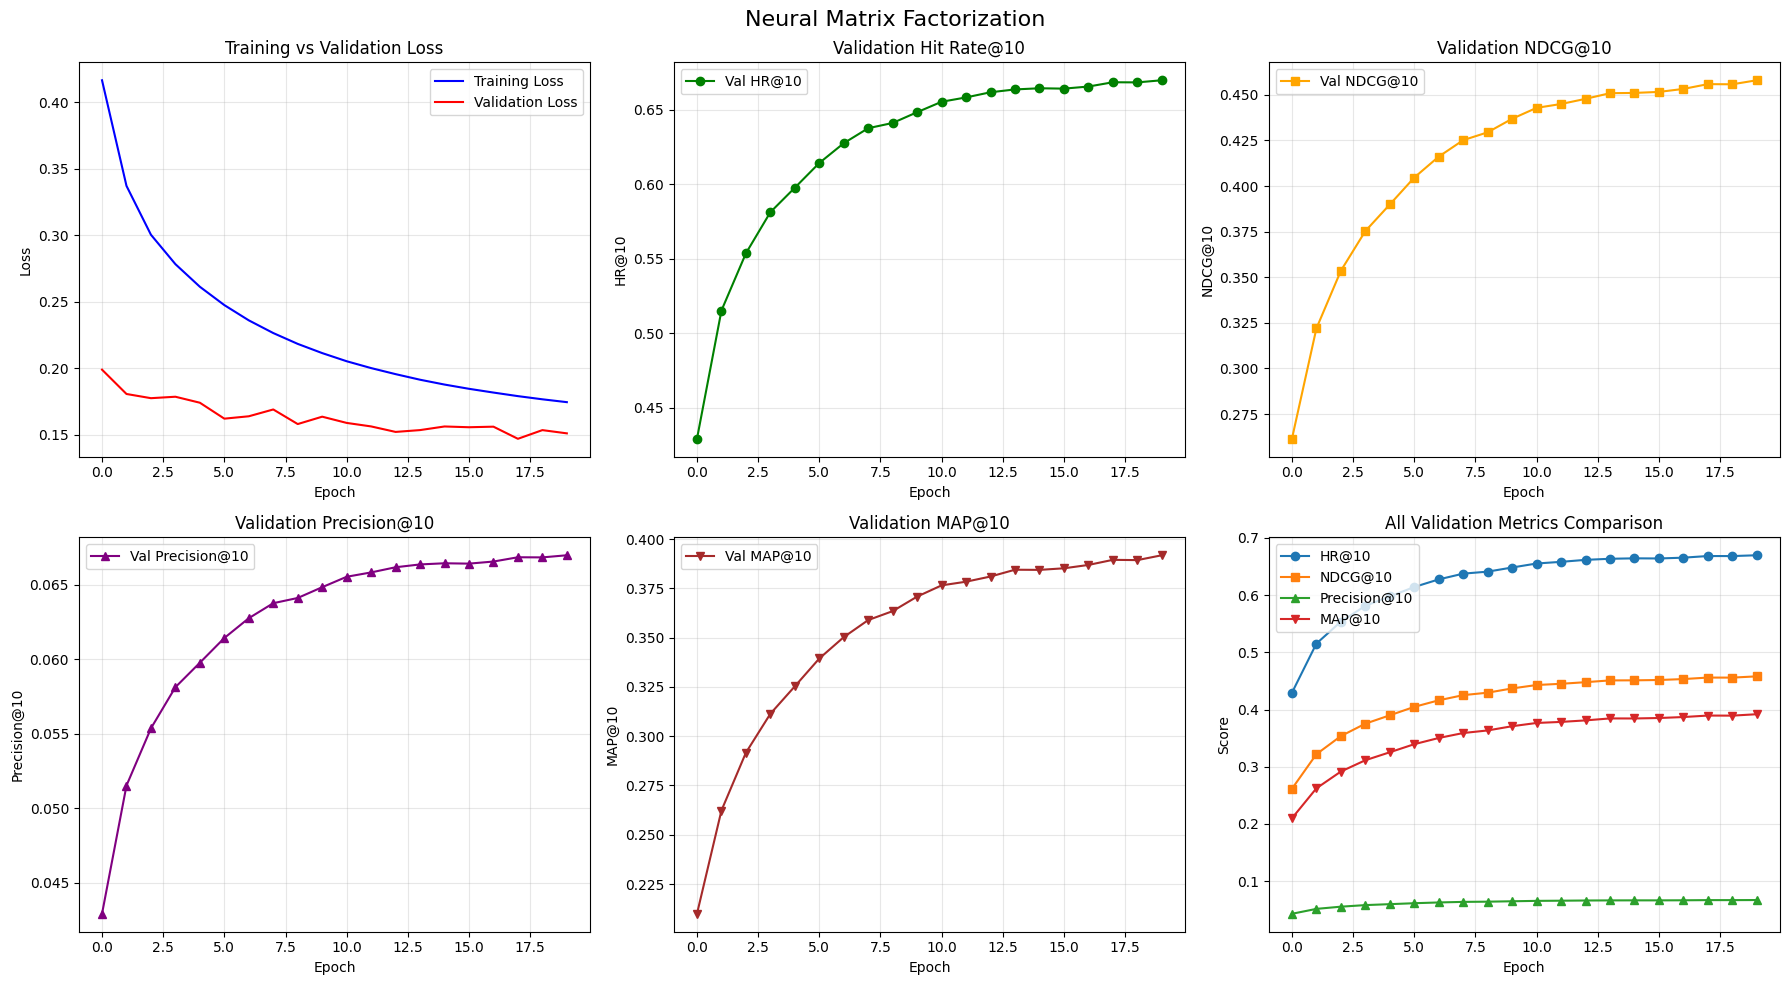

In [34]:
plot_training_history(
    train_losses_neumf,
    val_losses_neumf,
    val_metrics_neumf,
    k=10,
    model_name="Neural Matrix Factorization",
    save_path="training_history_neumf.png"
)

## Model 2: SASRec model
Transformer-based model for sequential recommendation from the paper [Self-Attentive Sequential Recommendation (2018)](https://arxiv.org/abs/1808.09781).

* **Data:** build per-user, time-sorted history sequences (left-padded to max length in batch). For training, use history -> next item triples + one negative per triples.
* **Model:** Item embeddings + positional embeddings -> Transformer encoder with causal mask. Take final position representation as the user's state and score candidate items by dot-product.
* **Eval:** Identical to the baseline using LOO setting.

In [65]:
# ORIGINAL
# def create_user_sequences(df):
#     df_sorted = df.sort_values(["user_id", "timestamp"])
#     user_sequences = {}
#     user_seq_lens = []
#     for uid, group in df_sorted.groupby("user_id"):
#         items = group["item_id"].tolist()
#         if len(items) >= 3:  # Need at least 3 for train/val/test split
#             user_sequences[uid] = items
#             user_seq_lens.append(len(items))
#
#     print(f"Created sequences for {len(user_sequences)} users.")
#     print(f"Average sequence length: {np.mean(user_seq_lens):.2f}")
#     print(f"Max sequence length: {np.max(user_seq_lens)}")
#     print(f"Min sequence length: {np.min(user_seq_lens)}")
#
#     return {
#         "sequences": user_sequences,
#         "avg_seq_len": np.mean(user_seq_lens),
#         "num_users": len(user_sequences)
#     }
#
# def shift_label_encoder(df):
#     df_enc = df.copy()
#     user_enc = LabelEncoder()
#     item_enc = LabelEncoder()
#     df_enc["user_id"] = user_enc.fit_transform(df_enc["user"])
#     df_enc["item_id"] = item_enc.fit_transform(df_enc["item"])
#     df_enc["item_id"] = df_enc["item_id"] + 1  # reserve 0 for padding → SASRec item IDs are +1
#     return {"encoded_df": df_enc,
#             "user_encoder": user_enc,
#             "item_encoder": item_enc}
#
# class SASRecDataset(Dataset):
#     def __init__(self, user_sequences, num_items, max_seq_len=50, mode="train", neg_samples=1):
#         self.user_sequences = user_sequences
#         self.num_items = num_items
#         self.max_seq_len = max_seq_len
#         self.mode = mode
#         self.neg_samples = neg_samples
#         self.users = list(user_sequences.keys())
#
#         # Set of all items each user has interacted with
#         self.user_item_set = {u: set(items) for u, items in user_sequences.items()}
#
#         self.samples = []
#         for user, seq in user_sequences.items():
#             if len(seq) < 3:
#                 continue
#             if mode == "train":
#                 for t in range(1, len(seq) - 2):
#                     input_seq = seq[:t]
#                     target = seq[t]
#                     self.samples.append((user, input_seq, target))
#             elif mode == "val":
#                 input_seq = seq[:-2]
#                 target = seq[-2]
#                 self.samples.append((user, input_seq, target))
#             else:  # test
#                 input_seq = seq[:-1]
#                 target = seq[-1]
#                 self.samples.append((user, input_seq, target))
#
#     def __len__(self):
#         return len(self.samples)
#
#     def __getitem__(self, idx):
#         user, input_seq, target = self.samples[idx]
#         if len(input_seq) > self.max_seq_len:
#             input_seq = input_seq[-self.max_seq_len:]
#         pad = self.max_seq_len - len(input_seq)
#         input_seq = [0] * pad + input_seq
#
#         neg_items = self._sample_negatives(user)
#
#         return {
#             "user": user,
#             "input_seq": torch.tensor(input_seq, dtype=torch.long),
#             "target": torch.tensor(target, dtype=torch.long), # target is a single item
#             "neg_items": torch.tensor(neg_items, dtype=torch.long)
#         }
#
#     def _sample_negatives(self, user):
#         # Negative sampling: sample items not in user's history
#         neg_items = set()
#         user_items = self.user_item_set[user]
#         while len(neg_items) < self.neg_samples:
#             neg = random.randint(1, self.num_items - 1)
#             if neg not in user_items:
#                 neg_items.add(neg)
#         return list(neg_items)
#
# sasrec_encoder = shift_label_encoder(filtered_df)
# df_encoded_sasrec = sasrec_encoder["encoded_df"]
#
# train_df_sasrec, val_df_sasrec, test_df_sasrec = loo_split(df_encoded_sasrec, oversample_verified=False, oversample_factor=1)
#
# SASREC_NUM_USERS = int(df_encoded_sasrec["user_id"].max()) + 1  # user IDs start at 0
# SASREC_NUM_ITEMS = int(df_encoded_sasrec["item_id"].max()) + 1  # item IDs start at 1, 0 is padding
#
# # Only keep users present in each split
# train_users_sasrec = set(train_df_sasrec["user_id"].unique())
# val_users_sasrec = set(val_df_sasrec["user_id"].unique())
# test_users_sasrec = set(test_df_sasrec["user_id"].unique())
#
# # Filter user sequences to match the splits
# user_sequences = create_user_sequences(df_encoded_sasrec)
# train_sequences = {u: seq for u, seq in user_sequences["sequences"].items() if u in train_users_sasrec}
# val_sequences = {u: seq for u, seq in user_sequences["sequences"].items() if u in val_users_sasrec}
# test_sequences = {u: seq for u, seq in user_sequences["sequences"].items() if u in test_users_sasrec}
#
# # train_sequences = {u: seq for u, seq in user_sequences["sequences"].items() if u in train_users_sasrec}
# # val_sequences = {u: seq for u, seq in user_sequences["sequences"].items() if u in train_users_sasrec}
# # test_sequences = {u: seq for u, seq in user_sequences["sequences"].items() if u in train_users_sasrec}
#
# # train_sequences = {u: seq[:-2] for u, seq in user_sequences["sequences"].items() if len(seq) >= 3}
# # val_sequences   = {u: seq[:] for u, seq in user_sequences["sequences"].items() if len(seq) >= 3}
# # test_sequences  = {u: seq[:] for u, seq in user_sequences["sequences"].items() if len(seq) >= 3}
#
# print("\n")
# print(f"Train sequences: {len(train_sequences)} users")
# print(f"Validation sequences: {len(val_sequences)} users")
# print(f"Test sequences: {len(test_sequences)} users")

Created sequences for 134397 users.
Average sequence length: 26.26
Max sequence length: 2221
Min sequence length: 3


Train sequences: 134397 users
Validation sequences: 130471 users
Test sequences: 130471 users


In [ ]:
def create_user_sequences(df):
    df_sorted = df.sort_values(["user_id", "timestamp"])
    user_sequences = {}
    user_seq_lens = []
    for uid, group in df_sorted.groupby("user_id"):
        items = group["item_id"].tolist()
        if len(items) >= 3:  # Need at least 3 for train/val/test split
            user_sequences[uid] = items
            user_seq_lens.append(len(items))

    print(f"Created sequences for {len(user_sequences)} users.")
    print(f"Average sequence length: {np.mean(user_seq_lens):.2f}")
    print(f"Max sequence length: {np.max(user_seq_lens)}")
    print(f"Min sequence length: {np.min(user_seq_lens)}")

    return {
        "sequences": user_sequences,
        "avg_seq_len": np.mean(user_seq_lens),
        "num_users": len(user_sequences)
    }

def shift_label_encoder(df):
    df_enc = df.copy()
    user_enc = LabelEncoder()
    item_enc = LabelEncoder()
    df_enc["user_id"] = user_enc.fit_transform(df_enc["user"])
    df_enc["item_id"] = item_enc.fit_transform(df_enc["item"])
    df_enc["item_id"] = df_enc["item_id"] + 1  # reserve 0 for padding → SASRec item IDs are +1
    return {"encoded_df": df_enc,
            "user_encoder": user_enc,
            "item_encoder": item_enc}

class SASRecDataset(Dataset):
    def __init__(self, user_sequences, num_items, max_seq_len=50, mode="train", neg_samples=1):
        self.user_sequences = user_sequences
        self.num_items = num_items
        self.max_seq_len = max_seq_len
        self.mode = mode
        self.neg_samples = neg_samples
        self.users = list(user_sequences.keys())

        # Set of all items each user has interacted with
        self.user_item_set = {u: set(items) for u, items in user_sequences.items()}

        self.samples = []
        for user, seq in user_sequences.items():
            if len(seq) < 3:
                continue
            if mode == "train":
                for t in range(1, len(seq) - 2):
                    input_seq = seq[:t]
                    target = seq[t]
                    self.samples.append((user, input_seq, target))
            elif mode == "val":
                input_seq = seq[:-2]
                target = seq[-2]
                self.samples.append((user, input_seq, target))
            else:  # test
                input_seq = seq[:-1]
                target = seq[-1]
                self.samples.append((user, input_seq, target))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        user, input_seq, target = self.samples[idx]
        if len(input_seq) > self.max_seq_len:
            input_seq = input_seq[-self.max_seq_len:]
        pad = self.max_seq_len - len(input_seq)
        input_seq = [0] * pad + input_seq

        neg_items = self._sample_negatives(user)

        return {
            "user": user,
            "input_seq": torch.tensor(input_seq, dtype=torch.long),
            "target": torch.tensor(target, dtype=torch.long), # target is a single item
            "neg_items": torch.tensor(neg_items, dtype=torch.long)
        }

    def _sample_negatives(self, user):
        # Negative sampling: sample items not in user's history
        neg_items = set()
        user_items = self.user_item_set[user]
        while len(neg_items) < self.neg_samples:
            neg = random.randint(1, self.num_items - 1)
            if neg not in user_items:
                neg_items.add(neg)
        return list(neg_items)

sasrec_encoder = shift_label_encoder(filtered_df)
df_encoded_sasrec = sasrec_encoder["encoded_df"]

train_df_sasrec, val_df_sasrec, test_df_sasrec = loo_split(df_encoded_sasrec)

SASREC_NUM_USERS = int(df_encoded_sasrec["user_id"].max()) + 1  # user IDs start at 0
SASREC_NUM_ITEMS = int(df_encoded_sasrec["item_id"].max()) + 1  # item IDs start at 1, 0 is padding

# Only keep users present in each split
train_users_sasrec = set(train_df_sasrec["user_id"].unique())
val_users_sasrec = set(val_df_sasrec["user_id"].unique())
test_users_sasrec = set(test_df_sasrec["user_id"].unique())

# Filter user sequences to match the splits
user_sequences = create_user_sequences(df_encoded_sasrec)
# train_sequences = {u: seq for u, seq in user_sequences["sequences"].items() if u in train_users_sasrec}
# val_sequences = {u: seq for u, seq in user_sequences["sequences"].items() if u in val_users_sasrec}
# test_sequences = {u: seq for u, seq in user_sequences["sequences"].items() if u in test_users_sasrec}

train_sequences = {u: seq for u, seq in user_sequences["sequences"].items() if u in train_users_sasrec}
val_sequences = {u: seq for u, seq in user_sequences["sequences"].items() if u in train_users_sasrec}
test_sequences = {u: seq for u, seq in user_sequences["sequences"].items() if u in train_users_sasrec}

# train_sequences = {u: seq[:-2] for u, seq in user_sequences["sequences"].items() if len(seq) >= 3}
# val_sequences   = {u: seq[:] for u, seq in user_sequences["sequences"].items() if len(seq) >= 3}
# test_sequences  = {u: seq[:] for u, seq in user_sequences["sequences"].items() if len(seq) >= 3}

print("\n")
print(f"Train sequences: {len(train_sequences)} users")
print(f"Validation sequences: {len(val_sequences)} users")
print(f"Test sequences: {len(test_sequences)} users")

In [84]:
train_dataset_sasrec = SASRecDataset(train_sequences, num_items=SASREC_NUM_ITEMS, max_seq_len=50, mode="train", neg_samples=1)
val_dataset_sasrec = SASRecDataset(val_sequences, num_items=SASREC_NUM_ITEMS, max_seq_len=50, mode="val", neg_samples=99)
test_dataset_sasrec = SASRecDataset(test_sequences, num_items=SASREC_NUM_ITEMS, max_seq_len=50, mode="test", neg_samples=99)

train_loader_sasrec = DataLoader(train_dataset_sasrec, batch_size=16384, shuffle=True)
val_loader_sasrec = DataLoader(val_dataset_sasrec, batch_size=4096, shuffle=False)
test_loader_sasrec = DataLoader(test_dataset_sasrec, batch_size=4096, shuffle=False)

In [85]:
first = next(iter(val_loader_sasrec))
print("Sample batch from validation loader:")
print("Input sequence shape:", first["input_seq"].shape)
print("Target shape:", first["target"].shape)
print("Negative items shape:", first["neg_items"].shape)

print("\nSample input sequence (first 2 in batch):")
for i in range(2):
    print(first["input_seq"][i].tolist())

Sample batch from validation loader:
Input sequence shape: torch.Size([4096, 50])
Target shape: torch.Size([4096])
Negative items shape: torch.Size([4096, 99])

Sample input sequence (first 2 in batch):
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 194221, 200712, 195429, 198542, 18272, 41955, 41911, 170908, 174672, 33798, 90532, 105377, 213396, 18609]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 45673, 36423, 66953, 35485, 27957, 45661, 45514, 687, 45639, 64862, 45487, 46290, 46739, 45474, 46097, 36572, 45623, 27981]


### Building the model

In [86]:
# Building SASRec model
class PointWiseFeedForward(nn.Module):
    def __init__(self, hidden_dim, dropout=0.2):
        super().__init__()
        self.w1 = nn.Linear(hidden_dim, hidden_dim)
        self.w2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w2(self.dropout(self.relu(self.w1(x))))

class AttentionBlock(nn.Module):
    def __init__(self, hidden_dim, num_heads, dropout=0.2):
        super().__init__()

        # Multi-head attention
        self.attn = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)

        # Layer norms
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)

        # Feed-forward network
        self.ffn = PointWiseFeedForward(hidden_dim, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, attn_mask=None):
        # Self-attention with residual connection
        attn_out, _ = self.attn(x, x, x, attn_mask=attn_mask)
        x = self.ln1(x + self.dropout(attn_out))

        # Feed-forward network with residual connection
        ffn_out = self.ffn(x)
        x = self.ln2(x + self.dropout(ffn_out))

        return x

class SASRec(nn.Module):
    def __init__(self,
                 num_items,
                 hidden_dim=64,
                 max_seq_len=50,
                 num_blocks=2,
                 num_heads=2,
                 dropout=0.2):
        super().__init__()

        self.num_items = num_items
        self.hidden_dim = hidden_dim
        self.max_seq_len = max_seq_len

        # Embedding layers
        self.item_embed = nn.Embedding(num_items, hidden_dim, padding_idx=0)
        self.positional_embed = nn.Embedding(max_seq_len, hidden_dim)
        self.dropout = nn.Dropout(dropout)

        # Stack of SASRec blocks
        self.blocks = nn.ModuleList([
            AttentionBlock(hidden_dim, num_heads, dropout) for _ in range(num_blocks)
        ])

        # Final layer norm
        self.ln = nn.LayerNorm(hidden_dim)

        # Initialize weights
        self._reset_parameters()

    def _reset_parameters(self):
        nn.init.xavier_normal_(self.item_embed.weight[1:])  # Skip padding idx
        nn.init.xavier_normal_(self.positional_embed.weight)

    def forward(self, input_seq, candidate_items=None):
        batch_size, seq_len = input_seq.shape

        # Get item embeddings
        item_embeds = self.item_embed(input_seq)  # [B, L, D]

        # Add positional embeddings
        positions = torch.arange(seq_len, device=input_seq.device).unsqueeze(0)
        pos_embeds = self.positional_embed(positions)  # [1, L, D]
        x = self.dropout(item_embeds + pos_embeds)

        # Create causal attention mask
        attn_mask = self._create_causal_mask(seq_len, input_seq.device)
        pad_mask = input_seq.eq(0)

        # Pass through transformer blocks
        for block in self.blocks:
            x = block(x, attn_mask=attn_mask)

        # Final layer norm
        x = self.ln(x)  # [B, L, D]
        x = x.masked_fill(pad_mask.unsqueeze(-1), 0.0)

        # If candidate_items provided, score them
        if candidate_items is not None:
            # Get embeddings for candidate items
            cand_emb = self.item_embed(candidate_items) # [B, N, D]

            # Use last position's representation for scoring
            last_hidden = x[:, -1, :].unsqueeze(1)  # [B, 1, D]

            # Compute scores via dot product
            scores = torch.matmul(last_hidden, cand_emb.transpose(1, 2)).squeeze(1) # [B, N]
            return scores

        return x

    def _create_causal_mask(self, seq_len, device):
        mask = torch.triu(torch.ones(seq_len, seq_len, device=device, dtype=torch.bool), diagonal=1)
        mask = mask.masked_fill(mask == 1, float("-inf"))
        return mask

    def predict_next(self, input_seq):
        # Get sequence representations
        seq_repr = self.forward(input_seq)  # [B, L, D]

        # Use last position for prediction
        last_hidden = seq_repr[:, -1, :]  # [B, D]

        # Score against all item embeddings
        all_item_embeds = self.item_embed.weight  # [num_items, D]
        scores = torch.matmul(last_hidden, all_item_embeds.T)  # [B, num_items]
        return scores

### Training the SASRec model

In [87]:
def train_sasrec_epoch(model, train_loader, loss_fn, optimizer, device="cpu"):
    model.train()
    total_loss = 0.0
    n_batches = 0

    for batch in tqdm(train_loader, desc="Training"):
        input_seq = batch["input_seq"].to(device)
        pos_items = batch["target"].to(device)
        neg_items = batch["neg_items"].to(device)

        # Get predictions for last position
        seq_output = model(input_seq)  # [B, L, D]
        last_hidden = seq_output[:, -1, :]  # [B, D]

        # Get embeddings for positive and negative items
        pos_embeds = model.item_embed(pos_items)
        neg_embeds = model.item_embed(neg_items)

        # Compute logits
        pos_logits = (last_hidden * pos_embeds).sum(dim=1)
        neg_logits = torch.bmm(neg_embeds, last_hidden.unsqueeze(-1)).squeeze(-1)

        # Binary cross-entropy loss with logits
        pos_labels = torch.ones_like(pos_logits)
        neg_labels = torch.zeros_like(neg_logits)

        # Concatenate logits and labels
        all_logits = torch.cat([pos_logits.unsqueeze(1), neg_logits], dim=1)
        all_labels = torch.cat([pos_labels.unsqueeze(1), neg_labels], dim=1)

        loss = loss_fn(all_logits, all_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        n_batches += 1

    return total_loss / n_batches

# Validation loss and ranking metrics
@torch.no_grad()
def evaluate_sasrec(model, eval_loader, loss_fn, k=10, device="cpu"):
    model.eval()
    total = 0
    sum_hr = 0.0
    sum_ndcg = 0.0
    sum_prec = 0.0
    sum_ap = 0.0

    sum_val_loss = 0.0
    n_loss_batches = 0

    for batch in tqdm(eval_loader, desc="Evaluating"):
        input_seq = batch["input_seq"].to(device)
        target = batch["target"].to(device)
        neg_items = batch["neg_items"].to(device)

        batch_size = input_seq.size(0)

        # Create candidate set: 1 positive + negatives
        seq_output = model(input_seq)  # [B, L, D]
        last_hidden = seq_output[:, -1, :]  # [B, D]
        candidates = torch.cat([
            target.unsqueeze(1),  # [B, 1]
            neg_items  # [B, neg_samples]
        ], dim=1)  # [B, 1 + neg_samples]

        # Get embeddings for all candidates
        cand_emb = model.item_embed(candidates)  # [B, 1+neg_samples, D]

        # Compute scores via dot product
        scores = torch.bmm(cand_emb, last_hidden.unsqueeze(-1)).squeeze(-1)  # [B, 1+neg_samples]

        # Loss calculation
        pos_scores = scores[:, 0]
        neg_scores = scores[:, 1:]
        pos_labels = torch.ones_like(scores[:, 0])
        neg_labels = torch.zeros_like(scores[:, 1:])
        all_scores = torch.cat([pos_scores.unsqueeze(1), neg_scores], dim=1)
        all_labels = torch.cat([pos_labels.unsqueeze(1), neg_labels], dim=1)
        batch_loss = loss_fn(all_scores.reshape(-1), all_labels.reshape(-1))
        sum_val_loss += batch_loss.item()
        n_loss_batches += 1

        # Calculate metrics
        _, full_idx = torch.sort(scores, dim=1, descending=True)
        rank = (full_idx == 0).nonzero(as_tuple=True)[1] + 1  # Rank of the positive item (1-based)

        hit = (rank <= k).float()
        ndcg = torch.where(rank <= k, 1.0 / torch.log2(rank.float() + 1), torch.zeros_like(hit))
        precision = hit / float(k)
        ap = torch.where(rank <= k, 1.0 / rank.float(), torch.zeros_like(hit))

        sum_hr += hit.sum().item()
        sum_ndcg += ndcg.sum().item()
        sum_prec += precision.sum().item()
        sum_ap += ap.sum().item()
        total += batch_size

    metrics = {
        "HR@K": sum_hr / total if total else 0.0,
        "NDCG@K": sum_ndcg / total if total else 0.0,
        "Precision@K": sum_prec / total if total else 0.0,
        "MAP@K": sum_ap / total if total else 0.0,
        "Val loss": sum_val_loss / max(n_loss_batches, 1)
    }

    return metrics

In [88]:
def sasrec_trainer(
        model,
        train_loader,
        eval_loader,
        epochs,
        loss_fn,
        optimizer,
        k=10,
        device="cpu",
        save_dir="model"
    ):
    os.makedirs(save_dir, exist_ok=True)
    model.to(device)
    writer = SummaryWriter()

    train_losses, val_losses, val_metrics_log = [], [], []
    best_ndcg, best_epoch = 0.0, 0

    for epoch in range(epochs):
        t0 = time.time()

        # Train (batched)
        train_loss = train_sasrec_epoch(model, train_loader, loss_fn, optimizer, device=device)
        train_losses.append(train_loss)

        # Eval (batched)
        m = evaluate_sasrec(model, eval_loader, loss_fn, k=k, device=device)
        val_losses.append(m["Val loss"])
        val_metrics_log.append({k_: m[k_] for k_ in ["HR@K", "NDCG@K", "Precision@K", "MAP@K"]})

        # Checkpointing by NDCG
        if m["NDCG@K"] > best_ndcg:
            best_ndcg = m["NDCG@K"]
            best_epoch = epoch + 1
            torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pth"))
        torch.save(model.state_dict(), os.path.join(save_dir, "last_model.pth"))

        # TB logs
        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Loss/Validation", m["Val loss"], epoch)
        writer.add_scalar(f"Metrics/Val_HR@{k}", m["HR@K"], epoch)
        writer.add_scalar(f"Metrics/Val_NDCG@{k}", m["NDCG@K"], epoch)
        writer.add_scalar(f"Metrics/Val_Precision@{k}", m["Precision@K"], epoch)
        writer.add_scalar(f"Metrics/Val_MAP@{k}", m["MAP@K"], epoch)

        print(
            f"Epoch {epoch+1}/{epochs}  "
            f"Train loss {train_loss:.4f}  "
            f"Val loss {m['Val loss']:.4f}  "
            f"HR@{k} {m['HR@K']:.4f}  "
            f"NDCG@{k} {m['NDCG@K']:.4f}  "
            f"Precision@{k} {m['Precision@K']:.4f}  "
            f"MAP@{k} {m['MAP@K']:.4f}  "
            f"{'(new best)' if m['NDCG@K'] == best_ndcg and best_epoch==epoch+1 else ''}  "
            f"Time {time.time()-t0:.2f}s"
        )

    # print("\n" + "="*50)
    print("\nTraining Complete.")
    print(f"Best epoch: {best_epoch} with NDCG@{k}: {best_ndcg:.4f}\n")
    # print("="*50)
    # print("\n")

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    writer.close()
    return train_losses, val_losses, val_metrics_log, best_ndcg

In [89]:
# Hyperparameters from the original paper, except higher hidden_dim
sasrec = SASRec(
    num_items=SASREC_NUM_ITEMS,
    hidden_dim=64,
    max_seq_len=50,
    num_blocks=2,
    num_heads=2,
    dropout=0.5
)

loss_fn_sasrec = nn.BCEWithLogitsLoss()
optimizer_sasrec = torch.optim.Adam(sasrec.parameters(), lr=1e-3, weight_decay=1e-6)

train_losses_sasrec, val_losses_sasrec, val_metrics_sasrec, best_ndcg_sasrec = sasrec_trainer(
    model=sasrec,
    train_loader=train_loader_sasrec,
    eval_loader=val_loader_sasrec,
    loss_fn=loss_fn_sasrec,
    optimizer=optimizer_sasrec,
    epochs=20,
    k=10,
    device=DEVICE,
    save_dir="model_sasrec"
)

Evaluating: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]


Epoch 1/20  Train loss 0.6047  Val loss 0.6164  HR@10 0.3455  NDCG@10 0.2060  Precision@10 0.0346  MAP@10 0.1634  (new best)  Time 155.52s


Evaluating: 100%|██████████| 32/32 [00:14<00:00,  2.25it/s]


Epoch 2/20  Train loss 0.5366  Val loss 0.6206  HR@10 0.4201  NDCG@10 0.2547  Precision@10 0.0420  MAP@10 0.2041  (new best)  Time 152.33s


Evaluating: 100%|██████████| 32/32 [00:17<00:00,  1.84it/s]


Epoch 3/20  Train loss 0.4896  Val loss 0.6014  HR@10 0.4601  NDCG@10 0.2765  Precision@10 0.0460  MAP@10 0.2204  (new best)  Time 156.50s


Evaluating: 100%|██████████| 32/32 [00:14<00:00,  2.26it/s]


Epoch 4/20  Train loss 0.4478  Val loss 0.5639  HR@10 0.5123  NDCG@10 0.3104  Precision@10 0.0512  MAP@10 0.2485  (new best)  Time 152.76s


Evaluating: 100%|██████████| 32/32 [00:14<00:00,  2.20it/s]


Epoch 5/20  Train loss 0.4099  Val loss 0.5359  HR@10 0.5497  NDCG@10 0.3372  Precision@10 0.0550  MAP@10 0.2719  (new best)  Time 151.14s


Evaluating: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]


Epoch 6/20  Train loss 0.3767  Val loss 0.4941  HR@10 0.5863  NDCG@10 0.3664  Precision@10 0.0586  MAP@10 0.2985  (new best)  Time 151.64s


Evaluating: 100%|██████████| 32/32 [00:14<00:00,  2.25it/s]


Epoch 7/20  Train loss 0.3466  Val loss 0.4663  HR@10 0.6167  NDCG@10 0.3955  Precision@10 0.0617  MAP@10 0.3270  (new best)  Time 152.19s


Evaluating: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]


Epoch 8/20  Train loss 0.3211  Val loss 0.4298  HR@10 0.6390  NDCG@10 0.4168  Precision@10 0.0639  MAP@10 0.3478  (new best)  Time 151.80s


Evaluating: 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]


Epoch 9/20  Train loss 0.2989  Val loss 0.4114  HR@10 0.6549  NDCG@10 0.4326  Precision@10 0.0655  MAP@10 0.3634  (new best)  Time 155.76s


Evaluating: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]


Epoch 10/20  Train loss 0.2808  Val loss 0.4031  HR@10 0.6688  NDCG@10 0.4477  Precision@10 0.0669  MAP@10 0.3787  (new best)  Time 151.62s


Evaluating: 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]


Epoch 11/20  Train loss 0.2663  Val loss 0.3829  HR@10 0.6771  NDCG@10 0.4578  Precision@10 0.0677  MAP@10 0.3893  (new best)  Time 153.46s


Evaluating: 100%|██████████| 32/32 [00:14<00:00,  2.20it/s]


Epoch 12/20  Train loss 0.2541  Val loss 0.3709  HR@10 0.6857  NDCG@10 0.4679  Precision@10 0.0686  MAP@10 0.3998  (new best)  Time 156.60s


Evaluating: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]


Epoch 13/20  Train loss 0.2441  Val loss 0.3578  HR@10 0.6897  NDCG@10 0.4715  Precision@10 0.0690  MAP@10 0.4033  (new best)  Time 155.33s


Evaluating: 100%|██████████| 32/32 [00:18<00:00,  1.75it/s]


Epoch 14/20  Train loss 0.2358  Val loss 0.3433  HR@10 0.6929  NDCG@10 0.4772  Precision@10 0.0693  MAP@10 0.4098  (new best)  Time 160.65s


Evaluating: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]


Epoch 15/20  Train loss 0.2283  Val loss 0.3349  HR@10 0.6963  NDCG@10 0.4821  Precision@10 0.0696  MAP@10 0.4151  (new best)  Time 158.93s


Evaluating: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]


Epoch 16/20  Train loss 0.2219  Val loss 0.3331  HR@10 0.7008  NDCG@10 0.4886  Precision@10 0.0701  MAP@10 0.4221  (new best)  Time 151.04s


Evaluating: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]


Epoch 17/20  Train loss 0.2159  Val loss 0.3159  HR@10 0.7022  NDCG@10 0.4910  Precision@10 0.0702  MAP@10 0.4248  (new best)  Time 150.65s


Evaluating: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]


Epoch 18/20  Train loss 0.2108  Val loss 0.3084  HR@10 0.7054  NDCG@10 0.4964  Precision@10 0.0705  MAP@10 0.4308  (new best)  Time 153.68s


Evaluating: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]


Epoch 19/20  Train loss 0.2056  Val loss 0.3022  HR@10 0.7077  NDCG@10 0.4986  Precision@10 0.0708  MAP@10 0.4331  (new best)  Time 162.96s


Evaluating: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]


Epoch 20/20  Train loss 0.2012  Val loss 0.3036  HR@10 0.7106  NDCG@10 0.5030  Precision@10 0.0711  MAP@10 0.4379  (new best)  Time 160.36s

Training Complete.
Best epoch: 20 with NDCG@10: 0.5030



### Final evaluation on test set

In [90]:
best_sasrec = load_best_weights(sasrec, ckpt_path="model_sasrec/best_model.pth", device=DEVICE)

NameError: name 'load_best_weights' is not defined

In [96]:
# Final evaluation on test set
@torch.no_grad()
def final_evaluation_sasrec(model, test_loader, loss_fn, k_values=(5,10,20,50), device="cpu") -> pd.DataFrame:
    rows = []
    for k in k_values:
        metrics = evaluate_sasrec(model, test_loader, loss_fn, k=k, device=device)
        rows.append({
            "K": k,
            "HR@K": metrics["HR@K"],
            "NDCG@K": metrics["NDCG@K"],
            "Precision@K": metrics["Precision@K"],
        })
    df = pd.DataFrame(rows).set_index("K").sort_index()
    print(df.to_string(float_format=lambda x: f"{x:.4f}"))
    return df

results_df_sasrec = final_evaluation_sasrec(best_sasrec, test_loader_sasrec, loss_fn_sasrec, device=DEVICE)

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

     HR@K  NDCG@K  Precision@K
K                             
5  0.1272  0.0771       0.0254
10 0.2021  0.1060       0.0202
20 0.3236  0.1353       0.0162
50 0.5718  0.1858       0.0114


In [97]:
@torch.no_grad()
def get_recommendations_sasrec(
        model,
        user_id,
        input_seq,
        pos_items_by_user,
        item_encoder,
        top_k=10,
        exclude_interacted=True,
        device="cpu"):

    model.eval()

    if len(input_seq) > model.max_seq_len:
        processed_seq = input_seq[-model.max_seq_len:]
    elif len(input_seq) < model.max_seq_len:
        processed_seq = [0] * (model.max_seq_len - len(input_seq)) + input_seq
    else:
        processed_seq = input_seq

    input_tensor = torch.tensor([processed_seq], dtype=torch.long, device=device)
    scores = model.predict_next(input_tensor).squeeze(0)

    # Exclude items the user has already interacted with
    if exclude_interacted and user_id in pos_items_by_user:
        interacted_indices = torch.as_tensor(
            list(pos_items_by_user[user_id]),
            dtype=torch.long,
            device=device
        )
        if interacted_indices.numel() > 0:
            scores.index_fill_(0, interacted_indices, float("-inf"))

    top_scores, top_indices = torch.topk(scores, top_k)
    item_ids_np = top_indices.detach().cpu().numpy()
    items_np = item_encoder.inverse_transform(item_ids_np)

    return [
        {"item_id": int(i), "item": it, "score": float(s)}
        for i, it, s in zip(item_ids_np, items_np, top_scores.detach().cpu().numpy())
    ]

In [98]:
def show_sample_recommendations_sasrec(
    model,
    df,
    user_encoder,
    item_encoder,
    pos_items_by_user,    # Used for filtering recommendations
    history_by_user,      # Used to get the input sequence for the model
    device,
    num_users=5,
    top_k=10):

    print("\n" + "="*50)
    print("SASRec - User Sample Recommendations")
    print("="*50)

    user_candidates = df["user_id"].unique().tolist()
    num_to_sample = min(num_users, len(user_candidates))

    for user_id in random.sample(user_candidates, k=num_to_sample):
        original_user = user_encoder.inverse_transform([user_id])[0]
        print(f"\nUser: {original_user} (ID: {user_id})")
        print("-" * 40)

        # Get the user's interaction history to show and to use as model input
        user_history_seq = history_by_user.get(user_id, [])

        # Display the 5 most recent interactions
        recent_interactions = user_history_seq[-5:]
        print("Recent interactions (most recent first):")
        for item_id in reversed(recent_interactions):
            item_name = item_encoder.inverse_transform([item_id])[0]
            print(f"  - {item_name} (ID: {item_id})")

        # Get recommendations using the adapted function
        recs = get_recommendations_sasrec(
            model=model,
            user_id=user_id,
            input_seq=user_history_seq, # Pass the full history as input
            pos_items_by_user=pos_items_by_user,
            item_encoder=item_encoder,
            device=device,
            top_k=top_k,
            exclude_interacted=True
        )

        print("\nTop 10 Recommendations:")
        for i, rec in enumerate(recs, 1):
            print(f"  {i}. {rec['item']} (ID: {rec['item_id']}, Score: {rec['score']:.4f})")

In [99]:
show_sample_recommendations_sasrec(
    model=best_sasrec,
    df=df_encoded,
    user_encoder=user_enc,
    item_encoder=item_enc,
    pos_items_by_user=pos_items_by_user,
    history_by_user=history_by_user_train,
    device=DEVICE,
    num_users=5,
    top_k=10
)


SASRec - User Sample Recommendations

User: AE2UD3I47HK2IY7EPSU4FCYB5Z5A (ID: 28)
----------------------------------------
Recent interactions (most recent first):
  - 0440245907 (ID: 2514)
  - 0440243696 (ID: 2510)
  - 1616202416 (ID: 6521)
  - 0062065254 (ID: 271)
  - 0060959037 (ID: 129)

Top 10 Recommendations:
  1. 0439023521 (ID: 2429, Score: 2.7689)
  2. 0439023513 (ID: 2428, Score: 2.7666)
  3. 0439042445 (ID: 2430, Score: 2.7614)
  4. 1476746826 (ID: 5659, Score: 2.7539)
  5. 0312577230 (ID: 1149, Score: 2.7454)
  6. 1594634025 (ID: 6316, Score: 2.6442)
  7. 0375843221 (ID: 1804, Score: 2.6388)
  8. 1524799017 (ID: 5990, Score: 2.6111)
  9. 052548342X (ID: 2947, Score: 2.5861)
  10. B00YUICLP0 (ID: 8816, Score: 2.5559)

User: AF5VPA7HEEI3XWE5V5R4SEYQQ55A (ID: 1389)
----------------------------------------
Recent interactions (most recent first):
  - 1501100122 (ID: 5822)
  - 159448385X (ID: 6298)
  - 1250105684 (ID: 4754)
  - 1476754454 (ID: 5669)
  - 0062200631 (ID: 319)

To

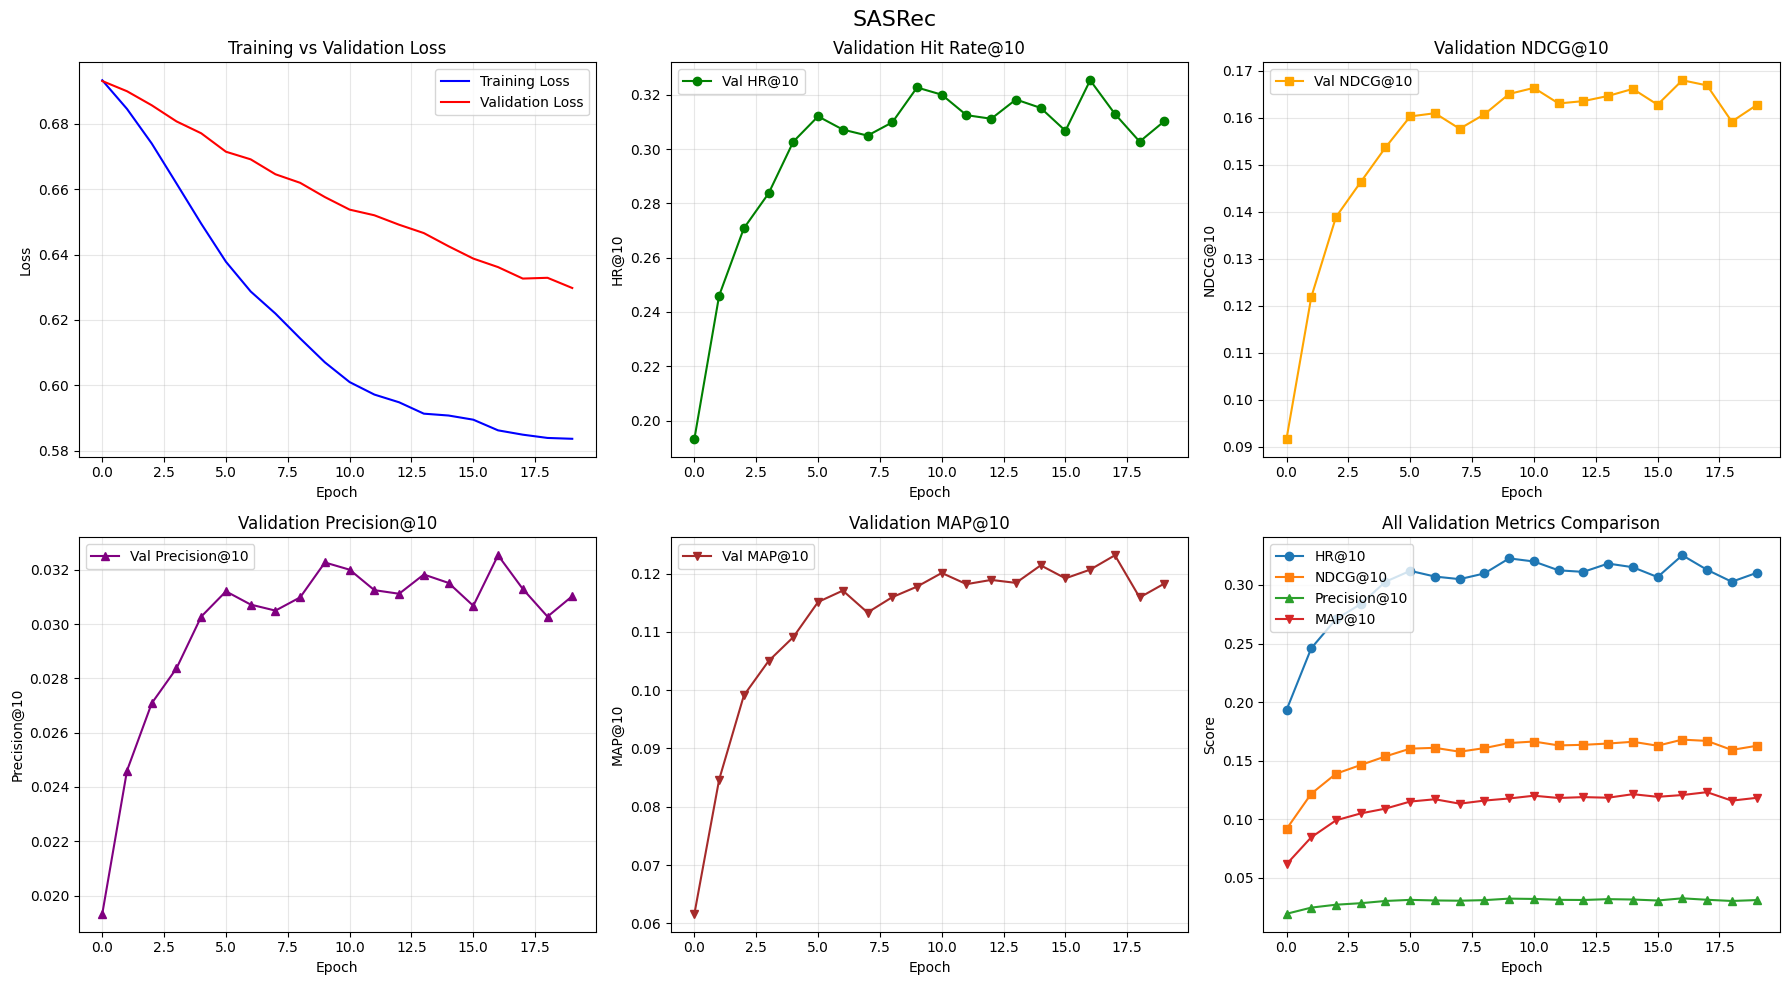

In [100]:
plot_training_history(
    train_losses_sasrec,
    val_losses_sasrec,
    val_metrics_sasrec,
    k=10,
    model_name="SASRec",
    save_path="training_history_sasrec.png"
)

## Comparison of all three models

In [119]:
# Plot metrics comparison at different K values
def plot_comparison(results_list, model_names, metric="NDCG@K", save_path="model_comparison.png"):
    plt.figure(figsize=(8, 6))
    for results, name in zip(results_list, model_names):
        plt.plot(results.index, results[metric], marker='o', label=name)
    plt.title(f"Comparison of {metric} Across Models in a Single Domain")
    plt.xlabel("K")
    plt.ylabel(metric)
    plt.xticks(results_list[0].index)
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    plt.show()

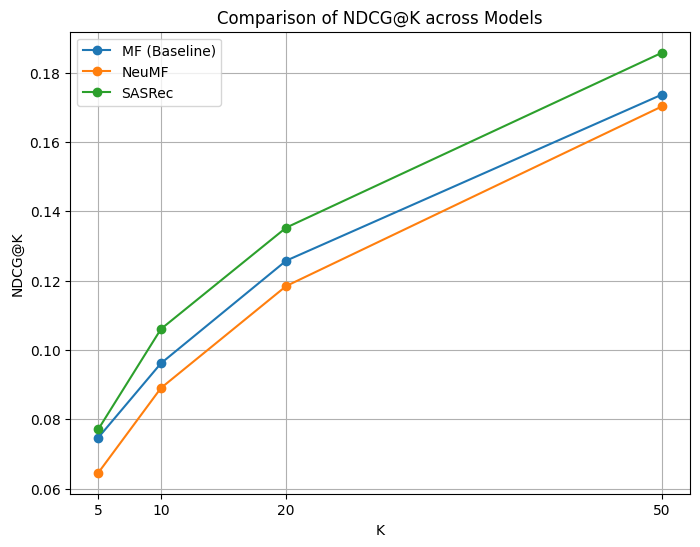

In [120]:
results_list = [results_df_mf, results_df_neumf, results_df_sasrec]
model_names = ["MF (Baseline)", "NeuMF", "SASRec"]
plot_comparison(results_list, model_names, metric="NDCG@K", save_path="ndcg_comparison.png")

## Cross-domain recommendation development